### NAMLSS Code & Helper Functions

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist

class NormalNAMLSS(nn.Module):
    def __init__(self, n_covariates, hidden_size=8, intercept=False):
        super(NormalNAMLSS, self).__init__()

        self.submodules = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, hidden_size),
                nn.Tanh(),
                nn.Linear(hidden_size, 2)
            ) for _ in range(n_covariates)
        ])

        self.use_intercept = intercept
        if self.use_intercept:
            self.intercept = nn.Parameter(torch.zeros(2))

    def forward(self, x):
        param_mat_list = [self.submodules[i](x[:, i:i + 1]) for i in range(x.shape[1])]
        x = torch.stack(param_mat_list, dim=1)
        mu_components = x[:, :, 0]
        sigma_components = F.softplus(x[:, :, 1])

        mu = torch.sum(mu_components, dim=1).unsqueeze(dim=1)
        sigma = torch.sum(sigma_components, dim=1).unsqueeze(dim=1)

        if self.use_intercept:
            mu = mu + self.intercept[0]
            sigma = sigma + F.softplus(self.intercept[1])

        return mu, sigma

    def nll_loss(self, mu, sigma, y_true, robustness_factor=None):
        normal_dist = dist.Normal(mu, sigma)
        log_likelihood = normal_dist.log_prob(y_true).mean()

        if robustness_factor is not None:
            log_likelihood = torch.log((1 + torch.exp(normal_dist.log_prob(y_true) + robustness_factor)) / (1 + torch.exp(robustness_factor))).mean() 

        nll = -log_likelihood
        return nll


    def fit(self, X_train, y_train, X_val=None, y_val=None, n_epochs=10000, lr=1e-3, weight_decay=0.0, 
            early_stopping_patience=10, robustness_factor=None):

        optimizer = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=weight_decay)

        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(n_epochs):
            self.train()

            # Forward pass and loss computation
            mu, sigma = self.forward(X_train)
            train_loss = self.nll_loss(mu, sigma, y_train, robustness_factor)

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            val_loss = None
            if X_val is not None and y_val is not None:
                self.eval()
                with torch.no_grad():
                    mu_val, sigma_val = self.forward(X_val)
                    val_loss = self.nll_loss(mu_val, sigma_val, y_val, robustness_factor).item()

                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    best_model_state = self.state_dict()
                else:
                    patience_counter += 1

                if (patience_counter >= early_stopping_patience) and (epoch >= 1000):
                    print(f"Early stopping at epoch {epoch}. Best validation loss: {best_val_loss:.4f}")
                    self.load_state_dict(best_model_state)
                    break

            if epoch % 100 == 0 or val_loss is not None:
                print(f"Epoch {epoch} - Train Loss: {train_loss.item():.4f} - Val Loss: {val_loss:.4f}" if val_loss else f"Epoch {epoch} - Train Loss: {train_loss.item():.4f}")

        return self
    
    def predict(self, x):
        mu, sigma = self.forward(x)

        mu = mu.detach()
        sigma = sigma.detach()

        return mu, sigma
        

    def marginal_effects(self, x):
        with torch.no_grad():
            param_mat_list = [self.submodules[i](x[:, i:i + 1]) for i in range(x.shape[1])]
            x = torch.stack(param_mat_list, dim=1)
            mu_components = x[:, :, 0].detach().cpu().numpy()
            sigma_components = F.softplus(x[:, :, 1]).detach().cpu().numpy()
        return mu_components, sigma_components

In [2]:
def F1(X):
    return (2 * X + torch.sin(X * 2.5 * torch.pi)).squeeze()

def F2(X):
    return (3 - 3 * X ** 2).squeeze()

def F3(X):
    return (12 * (X - 0.5) ** 2).squeeze()

def S1(X):
    return torch.exp(-0.5 + 2 * X - 1.5 * X ** 2).squeeze()

def S2(X):
    return (1.2 - 1/2 * X).squeeze()

def S3(X):
    return (X/X).squeeze()

### Simulation using 3 Covariates

In [3]:
import random
import torch.distributions as dist
from sklearn.preprocessing import StandardScaler


def simulation_run():

    ########## Drawing Covariate Samples ##########
    n_train, n_val, n_test = 10000, 10000, 10000
    prop_corrupt = 0.1
    n_var = 3
    Uniform = dist.Uniform(0, 1)

    X_train = Uniform.sample(sample_shape = [n_train, n_var])
    X_val = Uniform.sample(sample_shape = [n_val, n_var])
    X_test = Uniform.sample(sample_shape = [n_test, n_var])

    ########## Training Dataset ##########
    F1_train = F1(X_train[:,0])
    F2_train = F2(X_train[:,1])
    F3_train = F3(X_train[:,2])

    S1_train = S1(X_train[:,0])
    S2_train = S2(X_train[:,1])
    S3_train = S3(X_train[:,2])

    y_train = torch.normal(mean = F1_train + F2_train + F3_train, std = S1_train + S2_train + S3_train)
    corrupted_train_indices = torch.tensor(random.sample(range(1, n_train), int(n_train * prop_corrupt)))
    y_train[corrupted_train_indices] = torch.normal(torch.ones(len(corrupted_train_indices)) * 15, torch.ones(len(corrupted_train_indices)) * 2) # TODO: Bessere Outlier
    y_train = y_train.view(n_train, 1)

    intact_train_indices = torch.ones(n_train, dtype=bool)
    intact_train_indices[corrupted_train_indices] = False

    ########## Validation Dataset ###########
    F1_val = F1(X_val[:,0])
    F2_val = F2(X_val[:,1])
    F3_val = F3(X_val[:,2])

    S1_val = S1(X_val[:,0])
    S2_val = S2(X_val[:,1])
    S3_val = S3(X_val[:,2])

    y_val =  + torch.normal(mean = F1_val + F2_val + F3_val, std = S1_val + S2_val + S3_val)
    corrupted_val_indices = torch.tensor(random.sample(range(1, n_val), int(n_val * prop_corrupt)))
    y_val[corrupted_val_indices] = torch.normal(torch.ones(len(corrupted_val_indices)) * 15, torch.ones(len(corrupted_val_indices)) * 2) # TODO: Bessere Outlier
    y_val = y_val.view(n_val, 1)

    ########## Testing Dataset ##########
    F1_test = F1(X_test[:,0])
    F2_test = F2(X_test[:,1])
    F3_test = F3(X_test[:,2])

    S1_test = S1(X_test[:,0])
    S2_test = S2(X_test[:,1])
    S3_test = S3(X_test[:,2])

    y_test = torch.normal(mean = F1_test + F2_test + F3_test, std = S1_test + S2_test + S3_test)
    corrupted_test_indices = torch.tensor(random.sample(range(1, n_test), int(n_test * prop_corrupt)))
    y_test[corrupted_test_indices] = torch.normal(torch.ones(len(corrupted_test_indices)) * 15, torch.ones(len(corrupted_test_indices)) * 2) # TODO: Bessere Outlier

    y_test = y_test.view(n_test, 1)
    
    ########## Scaling the Data ##########
    scaler = StandardScaler()
    scaler1, scaler2, scaler3 = StandardScaler(), StandardScaler(), StandardScaler()

    X_train_scaled = torch.tensor(scaler.fit_transform(X_train), dtype = torch.float32)
    X_val_scaled = torch.tensor(scaler.fit_transform(X_val), dtype = torch.float32)
    X_test_scaled = torch.tensor(scaler.fit_transform(X_test), dtype = torch.float32)

    y_train_scaled = torch.tensor(scaler1.fit_transform(y_train), dtype = torch.float32)
    y_val_scaled = torch.tensor(scaler2.fit_transform(y_val), dtype = torch.float32)
    y_test_scaled = torch.tensor(scaler3.fit_transform(y_test), dtype = torch.float32)

    ########## Training the Networks ##########
    nam = NormalNAMLSS(3)
    nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor = None)

    robust_nam = NormalNAMLSS(3)
    robust_nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor=torch.tensor(3))

    strict_nam = NormalNAMLSS(3)
    strict_nam.fit(X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, robustness_factor=torch.tensor(1))

    ########## Predicting Parameters on Scaled Data ##########
    mu, sigma = nam.predict(X_test_scaled)
    rob_mu, rob_sigma = robust_nam.predict(X_test_scaled)
    strict_mu, strict_sigma = strict_nam.predict(X_test_scaled)

    mu_components, sigma_components = nam.marginal_effects(X_test_scaled)
    robust_mu_components, robust_sigma_components = robust_nam.marginal_effects(X_test_scaled)
    strict_mu_components, strict_sigma_components = strict_nam.marginal_effects(X_test_scaled)

    ########## Rescaling Predicted Parameters ##########
    mu = mu * scaler3.scale_ + scaler3.mean_
    rob_mu = rob_mu * scaler3.scale_ + scaler3.mean_
    strict_mu = strict_mu * scaler3.scale_ + scaler3.mean_

    sigma = sigma * scaler3.scale_
    rob_sigma = rob_sigma * scaler3.scale_
    strict_sigma = strict_sigma * scaler3.scale_

    mu_components = mu_components * scaler3.scale_ + scaler3.mean_
    robust_mu_components = robust_mu_components * scaler3.scale_ + scaler3.mean_
    strict_mu_components = strict_mu_components * scaler3.scale_ + scaler3.mean_

    sigma_components = sigma_components * scaler3.scale_
    robust_sigma_components = robust_sigma_components * scaler3.scale_
    strict_sigma_components = strict_sigma_components * scaler3.scale_

    ########## Return Dictionary with Relevant Information ##########
    
    run_result_dict = {
        "X_test": X_test,
        "y_test": y_test,
        "F1_test": F1_test,
        "F2_test": F2_test,
        "F3_test": F3_test,
        "S1_test": S1_test,
        "S2_test": S2_test,
        "S3_test": S3_test,
        "mu_components": mu_components,
        "robust_mu_components": robust_mu_components,
        "strict_mu_components": strict_mu_components,
        "sigma_components": sigma_components,
        "robust_sigma_components": robust_sigma_components,
        "strict_sigma_components": strict_sigma_components}
    
    return run_result_dict

In [4]:
def simulation(runs):
    result_list = [simulation_run() for _ in range(runs)]
    return result_list

In [21]:
import numpy as np
import pandas as pd

def get_mse(simulation_run_dict):

    F1_test = simulation_run_dict["F1_test"].numpy()
    F2_test = simulation_run_dict["F2_test"].numpy()
    F3_test = simulation_run_dict["F3_test"].numpy()
    mu_components = simulation_run_dict["mu_components"]
    robust_mu_components = simulation_run_dict["robust_mu_components"]
    strict_mu_components = simulation_run_dict["strict_mu_components"]

    S1_test = simulation_run_dict["S1_test"].numpy()
    S2_test = simulation_run_dict["S2_test"].numpy()
    S3_test = simulation_run_dict["S3_test"].numpy()
    sigma_components = simulation_run_dict["sigma_components"]
    robust_sigma_components = simulation_run_dict["robust_sigma_components"]
    strict_sigma_components = simulation_run_dict["strict_sigma_components"] 

    # Mu
    mean_mse_values = {
        "X1": [
            np.mean(((mu_components[:, 0] - mu_components[:, 0].mean()) - (F1_test - F1_test.mean())) ** 2),
            np.mean(((robust_mu_components[:, 0] - robust_mu_components[:, 0].mean()) - (F1_test - F1_test.mean())) ** 2),
            np.mean(((strict_mu_components[:, 0] - strict_mu_components[:, 0].mean()) - (F1_test - F1_test.mean())) ** 2)
        ],
        "X2": [
            np.mean(((mu_components[:, 1] - mu_components[:, 1].mean()) - (F2_test - F2_test.mean())) ** 2),
            np.mean(((robust_mu_components[:, 1] - robust_mu_components[:, 1].mean()) - (F2_test - F2_test.mean())) ** 2),
            np.mean(((strict_mu_components[:, 1] - strict_mu_components[:, 1].mean()) - (F2_test - F2_test.mean())) ** 2)
        ],
        "X3": [
            np.mean(((mu_components[:, 2] - mu_components[:, 2].mean()) - (F3_test - F3_test.mean())) ** 2),
            np.mean(((robust_mu_components[:, 2] - robust_mu_components[:, 2].mean()) - (F3_test - F3_test.mean())) ** 2),
            np.mean(((strict_mu_components[:, 2] - strict_mu_components[:, 2].mean()) - (F3_test - F3_test.mean())) ** 2)
        ]
    }

    # Sigma
    sigma_mse_values = {
        "X1": [
            np.mean(((sigma_components[:, 0] - sigma_components[:, 0].mean()) - (S1_test - S1_test.mean())) ** 2),
            np.mean(((robust_sigma_components[:, 0] - robust_sigma_components[:, 0].mean()) - (S1_test - S1_test.mean())) ** 2),
            np.mean(((strict_sigma_components[:, 0] - strict_sigma_components[:, 0].mean()) - (S1_test - S1_test.mean())) ** 2)
        ],
        "X2": [
            np.mean(((sigma_components[:, 1] - sigma_components[:, 1].mean()) - (S2_test - S2_test.mean())) ** 2),
            np.mean(((robust_sigma_components[:, 1] - robust_sigma_components[:, 1].mean()) - (S2_test - S2_test.mean())) ** 2),
            np.mean(((strict_sigma_components[:, 1] - strict_sigma_components[:, 1].mean()) - (S2_test - S2_test.mean())) ** 2)
        ],
        "X3": [
            np.mean(((sigma_components[:, 2] - sigma_components[:, 2].mean()) - (S3_test - S3_test.mean())) ** 2),
            np.mean(((robust_sigma_components[:, 2] - robust_sigma_components[:, 2].mean()) - (S3_test - S3_test.mean())) ** 2),
            np.mean(((strict_sigma_components[:, 2] - strict_sigma_components[:, 2].mean()) - (S3_test - S3_test.mean())) ** 2)
        ]
    }

    mean_mse_df = pd.DataFrame(mean_mse_values, index=["mu", "robust_mu", "strict_mu"]).round(5)
    sigma_mse_df = pd.DataFrame(sigma_mse_values, index=["sigma", "robust_sigma", "strict_sigma"]).round(5)

    return {"Mean_MSE":mean_mse_df,
            "Sigma_MSE":sigma_mse_df}

In [22]:
def simulation_mse_tables(simulation_runs):
    mean_mse_list = []
    sigma_mse_list = []
    
    for run_dict in simulation_runs:

        mse_results = get_mse(run_dict)
        
        mean_mse_list.append(mse_results["Mean_MSE"].values)
        sigma_mse_list.append(mse_results["Sigma_MSE"].values)
    
    mean_mse_array = np.array(mean_mse_list)  # Shape: (num_runs, 3, 3)
    sigma_mse_array = np.array(sigma_mse_list)

    # Compute averages across simulation runs
    mean_mse_avg = np.mean(mean_mse_array, axis = 0)
    sigma_mse_avg = np.mean(sigma_mse_array, axis = 0)

    # Convert back to DataFrame
    mean_mse_df = pd.DataFrame(mean_mse_avg, columns = ["X1", "X2", "X3"], index = ["mu", "robust_mu", "strict_mu"]).round(5)
    sigma_mse_df = pd.DataFrame(sigma_mse_avg, columns = ["X1", "X2", "X3"], index = ["sigma", "robust_sigma", "strict_sigma"]).round(5)

    return {"Mean_MSE_Avg": mean_mse_df, "Sigma_MSE_Avg": sigma_mse_df}


In [7]:
simulation_list = simulation(10)

Epoch 0 - Train Loss: 1.7688 - Val Loss: 1.7635
Epoch 1 - Train Loss: 1.7640 - Val Loss: 1.7587
Epoch 2 - Train Loss: 1.7592 - Val Loss: 1.7540
Epoch 3 - Train Loss: 1.7545 - Val Loss: 1.7493
Epoch 4 - Train Loss: 1.7498 - Val Loss: 1.7446
Epoch 5 - Train Loss: 1.7451 - Val Loss: 1.7400
Epoch 6 - Train Loss: 1.7405 - Val Loss: 1.7354
Epoch 7 - Train Loss: 1.7359 - Val Loss: 1.7308
Epoch 8 - Train Loss: 1.7314 - Val Loss: 1.7263
Epoch 9 - Train Loss: 1.7269 - Val Loss: 1.7219
Epoch 10 - Train Loss: 1.7224 - Val Loss: 1.7175
Epoch 11 - Train Loss: 1.7180 - Val Loss: 1.7131
Epoch 12 - Train Loss: 1.7136 - Val Loss: 1.7088
Epoch 13 - Train Loss: 1.7093 - Val Loss: 1.7045
Epoch 14 - Train Loss: 1.7051 - Val Loss: 1.7003
Epoch 15 - Train Loss: 1.7009 - Val Loss: 1.6961
Epoch 16 - Train Loss: 1.6967 - Val Loss: 1.6920
Epoch 17 - Train Loss: 1.6926 - Val Loss: 1.6879
Epoch 18 - Train Loss: 1.6885 - Val Loss: 1.6839
Epoch 19 - Train Loss: 1.6845 - Val Loss: 1.6799
Epoch 20 - Train Loss: 1.6806 

In [24]:
table = simulation_mse_tables(simulation_list)
table["Mean_MSE_Avg"] * 100

,X1,X2,X3
mu,1.802,1.625,1.463
robust_mu,1.637,0.644,0.631
strict_mu,1.670,0.705,0.560


In [25]:
table["Sigma_MSE_Avg"] * 100

,X1,X2,X3
sigma,3.303,8.244,3.741
robust_sigma,0.384,0.312,0.339
strict_sigma,1.715,0.433,0.258


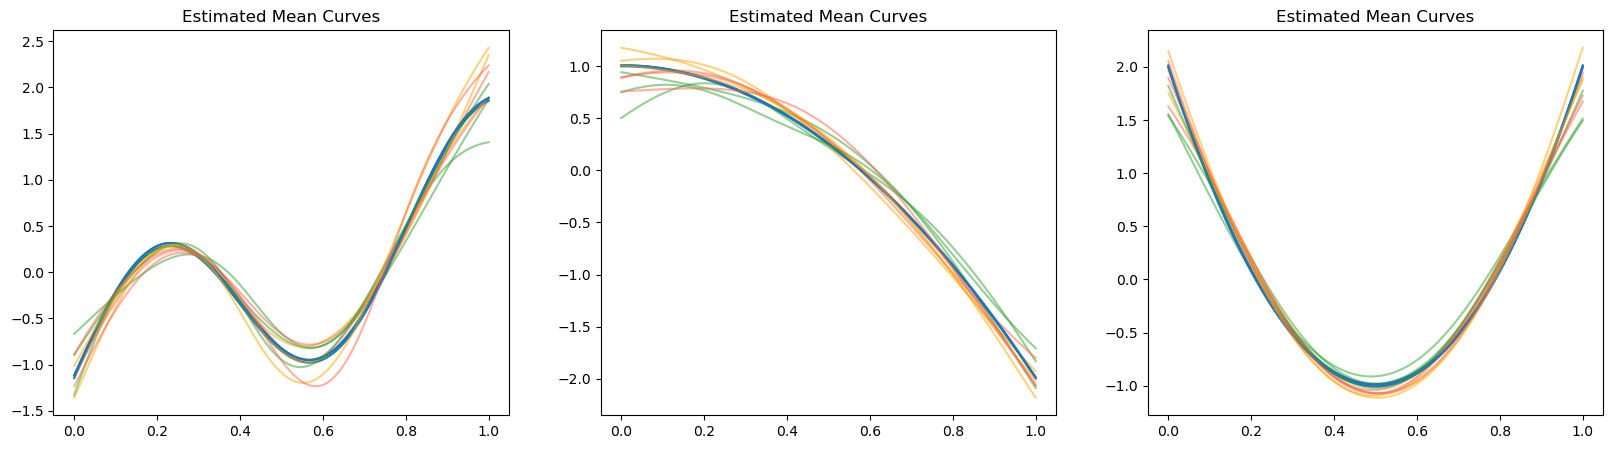

In [49]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = [20, 5])

for element in simulation_list:

    X_test = element["X_test"].numpy()
    F1_test = element["F1_test"].numpy()
    F2_test = element["F2_test"].numpy()
    F3_test = element["F3_test"].numpy()
    mu_components = element["mu_components"]
    robust_mu_components = element["robust_mu_components"]
    strict_mu_components = element["strict_mu_components"]

    S1_test = element["S1_test"].numpy()
    S2_test = element["S2_test"].numpy()
    S3_test = element["S3_test"].numpy()
    sigma_components = element["sigma_components"]
    robust_sigma_components = element["robust_sigma_components"]
    strict_sigma_components = element["strict_sigma_components"] 

    markersize = 1
    alpha = 0.5

    true_color = "C0"
    unregulated_color = "C2"
    robust_color = "orange"
    strict_color = "tomato"

    sorted_indices = np.argsort(X_test[:, 0])
    X_sorted = X_test[sorted_indices, 0]
    F1_sorted = (F1_test - F1_test.mean())[sorted_indices]

    axes[0].plot(X_sorted, (F1_test - F1_test.mean())[sorted_indices], color = true_color, markersize = markersize + 2)
    axes[0].plot(X_sorted, (mu_components[:,0] - mu_components[:,0].mean())[sorted_indices], color = unregulated_color, markersize = markersize, alpha = alpha)
    axes[0].plot(X_sorted, (robust_mu_components[:,0] - robust_mu_components[:,0].mean())[sorted_indices], color = robust_color, markersize = markersize, alpha = alpha)
    axes[0].plot(X_sorted, (strict_mu_components[:,0] - strict_mu_components[:,0].mean())[sorted_indices], color = strict_color, markersize = markersize, alpha = alpha)
    axes[0].set_title("Estimated Mean Curves")

    sorted_indices = np.argsort(X_test[:, 1])
    X_sorted = X_test[sorted_indices, 1]
    F2_sorted = (F2_test - F2_test.mean())[sorted_indices]

    axes[1].plot(X_sorted, (F2_test - F2_test.mean())[sorted_indices], color = true_color, markersize = markersize + 2)
    axes[1].plot(X_sorted, (mu_components[:,1] - mu_components[:,1].mean())[sorted_indices], color = unregulated_color, markersize = markersize, alpha = alpha)
    axes[1].plot(X_sorted, (robust_mu_components[:,1] - robust_mu_components[:,1].mean())[sorted_indices], color = robust_color, markersize = markersize, alpha = alpha)
    axes[1].plot(X_sorted, (strict_mu_components[:,1] - strict_mu_components[:,1].mean())[sorted_indices], color = strict_color, markersize = markersize, alpha = alpha)
    axes[1].set_title("Estimated Mean Curves")

    sorted_indices = np.argsort(X_test[:, 2])
    X_sorted = X_test[sorted_indices, 2]
    F3_sorted = (F3_test - F3_test.mean())[sorted_indices]

    axes[2].plot(X_sorted, (F3_test - F3_test.mean())[sorted_indices], color = true_color, markersize = markersize + 2)
    axes[2].plot(X_sorted, (mu_components[:,2] - mu_components[:,2].mean())[sorted_indices], color = unregulated_color, markersize = markersize, alpha = alpha)
    axes[2].plot(X_sorted, (robust_mu_components[:,2] - robust_mu_components[:,2].mean())[sorted_indices], color = robust_color, markersize = markersize, alpha = alpha)
    axes[2].plot(X_sorted, (strict_mu_components[:,2] - strict_mu_components[:,2].mean())[sorted_indices], color = strict_color, markersize = markersize, alpha = alpha)
    axes[2].set_title("Estimated Mean Curves")


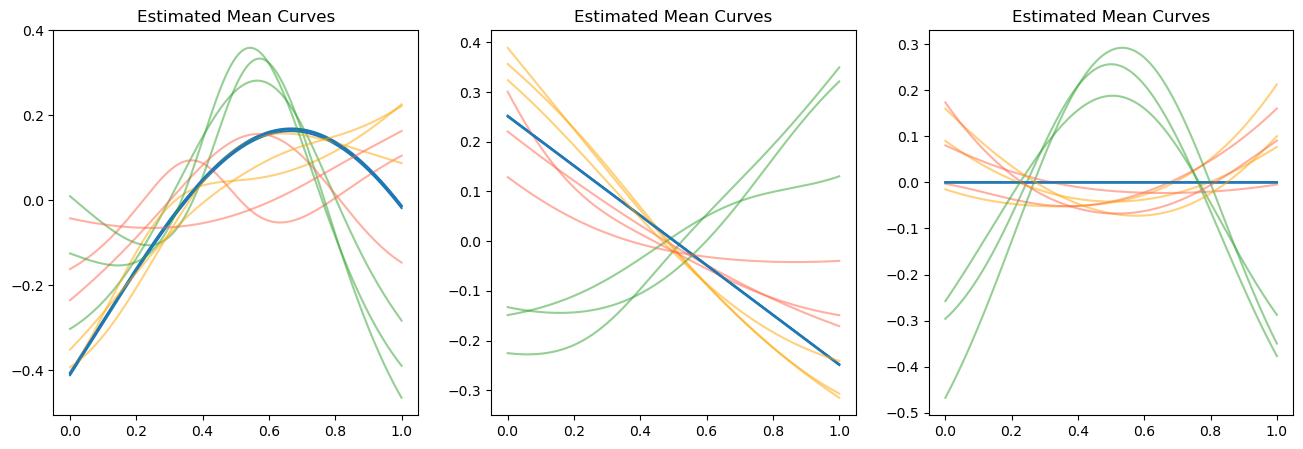

In [50]:
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = [16, 5])

for element in simulation_list:

    X_test = element["X_test"].numpy()
    F1_test = element["F1_test"].numpy()
    F2_test = element["F2_test"].numpy()
    F3_test = element["F3_test"].numpy()
    mu_components = element["mu_components"]
    robust_mu_components = element["robust_mu_components"]
    strict_mu_components = element["strict_mu_components"]

    S1_test = element["S1_test"].numpy()
    S2_test = element["S2_test"].numpy()
    S3_test = element["S3_test"].numpy()
    sigma_components = element["sigma_components"]
    robust_sigma_components = element["robust_sigma_components"]
    strict_sigma_components = element["strict_sigma_components"] 

    markersize = 1
    alpha = 0.5

    true_color = "C0"
    unregulated_color = "C2"
    robust_color = "orange"
    strict_color = "tomato"

    sorted_indices = np.argsort(X_test[:, 0])
    X_sorted = X_test[sorted_indices, 0]
    S1_sorted = (S1_test - S1_test.mean())[sorted_indices]

    axes[0].plot(X_sorted, (S1_test - S1_test.mean())[sorted_indices], color = true_color, markersize = markersize + 2)
    axes[0].plot(X_sorted, (sigma_components[:,0] - sigma_components[:,0].mean())[sorted_indices], color = unregulated_color, markersize = markersize, alpha = alpha)
    axes[0].plot(X_sorted, (robust_sigma_components[:,0] - robust_sigma_components[:,0].mean())[sorted_indices], color = robust_color, markersize = markersize, alpha = alpha)
    axes[0].plot(X_sorted, (strict_sigma_components[:,0] - strict_sigma_components[:,0].mean())[sorted_indices], color = strict_color, markersize = markersize, alpha = alpha)
    axes[0].set_title("Estimated Sigma Curves")

    sorted_indices = np.argsort(X_test[:, 1])
    X_sorted = X_test[sorted_indices, 1]
    S2_sorted = (S2_test - S2_test.mean())[sorted_indices]

    axes[1].plot(X_sorted, (S2_test - S2_test.mean())[sorted_indices], color = true_color, markersize = markersize + 2)
    axes[1].plot(X_sorted, (sigma_components[:,1] - sigma_components[:,1].mean())[sorted_indices], color = unregulated_color, markersize = markersize, alpha = alpha)
    axes[1].plot(X_sorted, (robust_sigma_components[:,1] - robust_sigma_components[:,1].mean())[sorted_indices], color = robust_color, markersize = markersize, alpha = alpha)
    axes[1].plot(X_sorted, (strict_sigma_components[:,1] - strict_sigma_components[:,1].mean())[sorted_indices], color = strict_color, markersize = markersize, alpha = alpha)
    axes[1].set_title("Estimated Sigma Curves")

    sorted_indices = np.argsort(X_test[:, 2])
    X_sorted = X_test[sorted_indices, 2]
    S3_sorted = (S3_test - S3_test.mean())[sorted_indices]

    axes[2].plot(X_sorted, (S3_test - S3_test.mean())[sorted_indices], color = true_color, markersize = markersize + 2)
    axes[2].plot(X_sorted, (sigma_components[:,2] - sigma_components[:,2].mean())[sorted_indices], color = unregulated_color, markersize = markersize, alpha = alpha)
    axes[2].plot(X_sorted, (robust_sigma_components[:,2] - robust_sigma_components[:,2].mean())[sorted_indices], color = robust_color, markersize = markersize, alpha = alpha)
    axes[2].plot(X_sorted, (strict_sigma_components[:,2] - strict_sigma_components[:,2].mean())[sorted_indices], color = strict_color, markersize = markersize, alpha = alpha)
    axes[2].set_title("Estimated Sigma Curves")